In [1]:
import importlib
import os
from datasets.hdf5 import get_test_loaders
from unet3d import utils
from unet3d.model import get_model
import h5py
import hdbscan
import numpy as np
import time
import torch
import yaml

%matplotlib inline

In [8]:
input_arr = []

class _AbstractPredictor:
    def __init__(self, model, loader, config, **kwargs):
        self.model = model
        self.loader = loader['test']
        self.config = config
        self.predictor_config = kwargs

    @staticmethod
    def _volume_shape(dataset):
        raw = dataset.raws
        if raw.ndim == 3:
            return raw.shape
        else:
            return raw.shape[1:]

    def predict(self):
        raise NotImplementedError


class StandardPredictor(_AbstractPredictor):

    def __init__(self, model, loader, config, **kwargs):
        super().__init__(model, loader, config, **kwargs)
        self.device = self.config['device']

    def predict(self):

        # Sets the module in evaluation mode explicitly, otherwise the final Softmax/Sigmoid won't be applied!
        self.model.eval()
        
        pred_arr = []
        target_arr = []
        # Run predictions on the entire input dataset
        with torch.no_grad():
            for i, data_pair in enumerate(self.loader):
                input, target = self._split_testing_data(data_pair)
                input_arr.append(input)
                prediction = self.model(input)
                print(prediction.shape)
                pred_arr.append(prediction)
                target_arr.append(target)
                
        return pred_arr, target_arr
    
    def _split_testing_data(self, t):
        def _move_to_device(input):
            if isinstance(input, tuple) or isinstance(input, list):
                return tuple([_move_to_device(x) for x in input])
            else:
                input = input.float()
                return input.to(self.device)

        t = _move_to_device(t)
        input, target = t
        return input, target
                


In [9]:
logger = utils.get_logger('UNet3DPredictor')
DEFAULT_DEVICE = 'cuda:0'

def load_config():

    args = 'resources/test_config_4d_input.yaml'
    config = _load_config_yaml(args)
    # Get a device to train on
    device = config.get('device', DEFAULT_DEVICE)
    config['device'] = torch.device(device)
    return config


def _load_config_yaml(config_file):
    return yaml.load(open(config_file, 'r'))


def _get_predictor(model, loader, config):
    predictor_config = config.get('predictor', {})

    # model: UNet3D, loader: test_loader, config: config.yaml
    return StandardPredictor(model, loader, config, **predictor_config)


def main():
    # Load configuration
    config = load_config()

    # Create the model
    model = get_model(config)

    # Load model state
    model_path = config['model_path']
    logger.info(f'Loading model from {model_path}...')
    utils.load_checkpoint(model_path, model)
    logger.info(f"Sending the model to '{config['device']}'")
    model = model.to(config['device'])

    logger.info('Loading HDF5 datasets...')

    test_loader = get_test_loaders(config)
    predictor = _get_predictor(model, test_loader, config)
    pred, target =  predictor.predict()
    
    return pred, target

In [10]:
pred, tar = main()

4 3
2019-12-22 22:09:51,202 [MainThread] INFO UNet3DPredictor - Loading model from 3dunet/best_checkpoint.pytorch...
2019-12-22 22:09:51,202 [MainThread] INFO UNet3DPredictor - Loading model from 3dunet/best_checkpoint.pytorch...
2019-12-22 22:09:51,271 [MainThread] INFO UNet3DPredictor - Sending the model to 'cuda:0'
2019-12-22 22:09:51,271 [MainThread] INFO UNet3DPredictor - Sending the model to 'cuda:0'
2019-12-22 22:09:51,283 [MainThread] INFO UNet3DPredictor - Loading HDF5 datasets...
2019-12-22 22:09:51,283 [MainThread] INFO UNet3DPredictor - Loading HDF5 datasets...
2019-12-22 22:09:51,285 [MainThread] INFO HDF5Dataset - Number of workers for the dataloader: 8
2019-12-22 22:09:51,286 [MainThread] INFO HDF5Dataset - Batch size for dataloader: 1
Phase now:  test


/home/ml/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])
torch.Size([1, 3, 128, 160, 160])


RuntimeError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 11.91 GiB total capacity; 9.55 GiB already allocated; 168.56 MiB free; 1.67 GiB cached)

In [7]:
print(pred[0][0].size(0))
print(input_arr[0][0].size(0))
tmp_arr = []
for i in range(len(input_arr)):
    tmp_data = input_arr[i][0].cpu().numpy()
    tmp_arr.append(tmp_data)
    
input_arr = tmp_arr
print(input_arr)

3
4
[array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],

In [11]:
import matplotlib.pyplot as plt

label_types = ['NCR & NET', 'ED', 'ET']
modalities = ['flair', 't1', 't1ce', 't2']

def plot_pred_img(img_data, phase, patientID):

    n_channels, n_slices, height, width = img_data.shape
    m_s = n_slices // 2
    
    fig = plt.figure(figsize=(20, 4))
    for n_c in range(n_channels):
        title = patientID + ' ' + phase + ' modality: ' + label_types[n_c] + ' slice: ' + str(m_s)
        ax = fig.add_subplot(1, n_channels, n_c+1)
        ax.title.set_text(title)
        ax.imshow(img_data[n_c, m_s, :, :])
    plt.show()
    
def plot_original_img(img_data, phase, patientID):
    n_channels, n_slices, height, width = img_data.shape
    m_s = n_slices // 2
    
    fig = plt.figure(figsize=(20, 4))
    for n_c in range(n_channels):
        title = patientID + ' ' + phase + ' modality: ' + modalities[n_c] + ' slice: ' + str(m_s)
        ax = fig.add_subplot(1, n_channels, n_c+1)
        ax.title.set_text(title)
        ax.imshow(img_data[n_c, m_s, :, :])
    plt.show()  

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


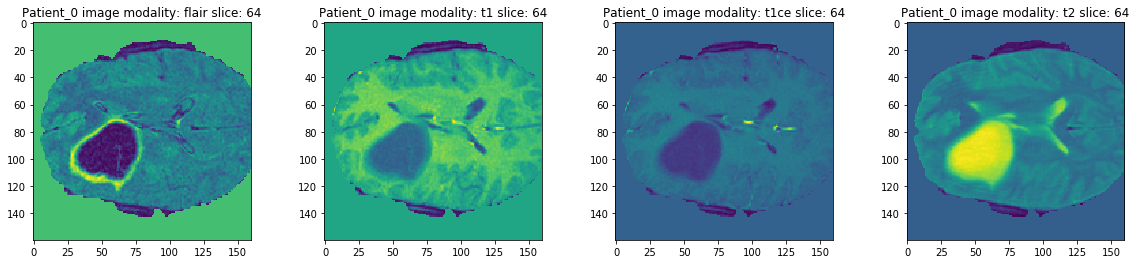

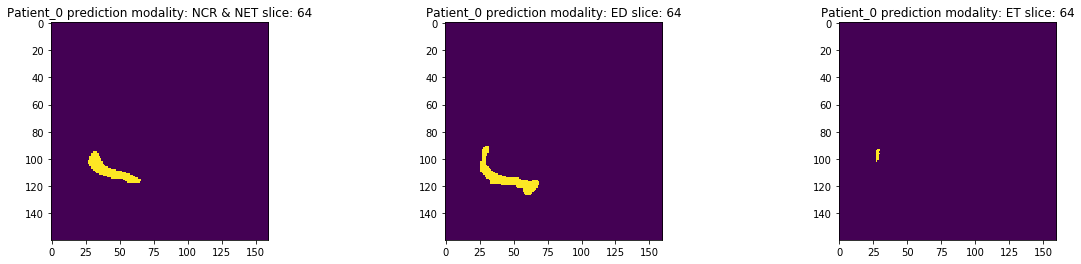

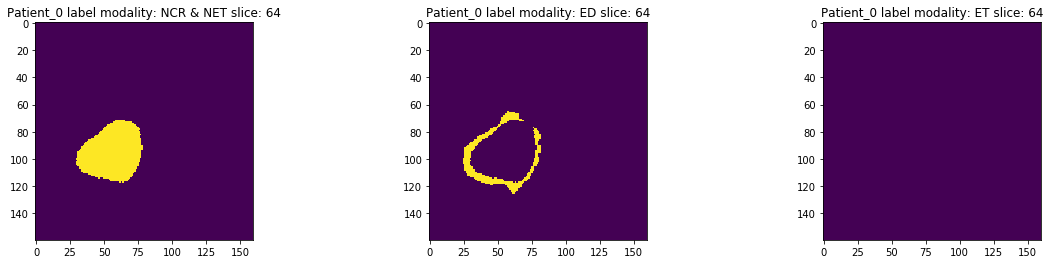

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


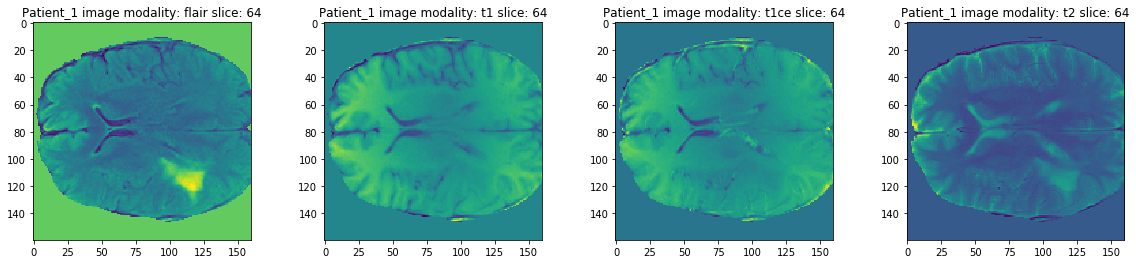

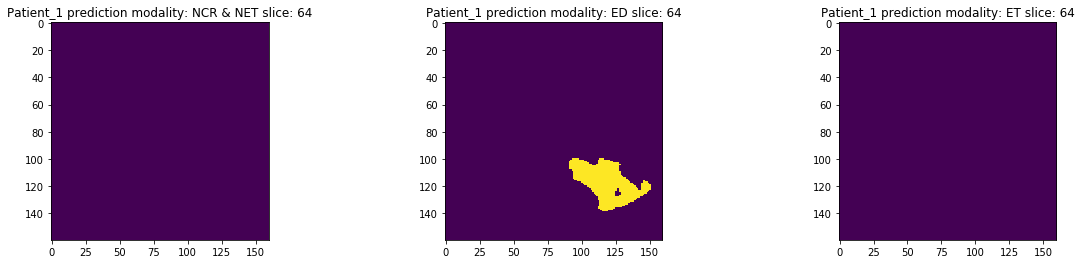

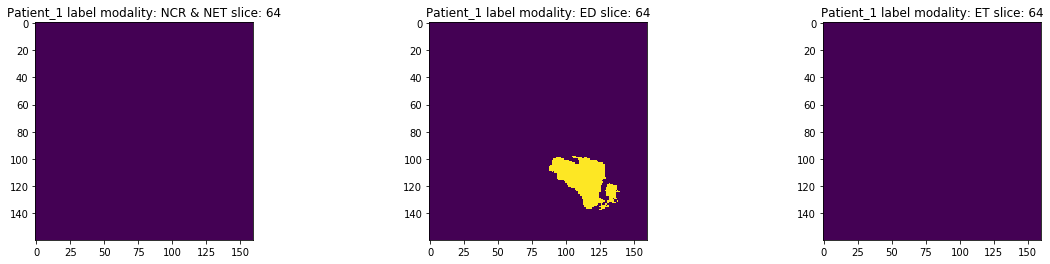

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


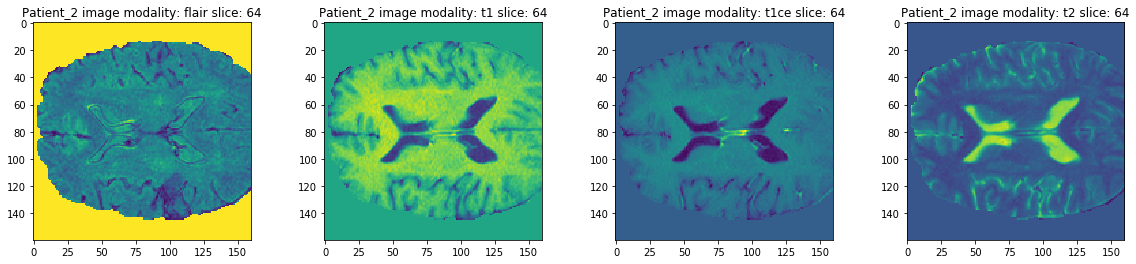

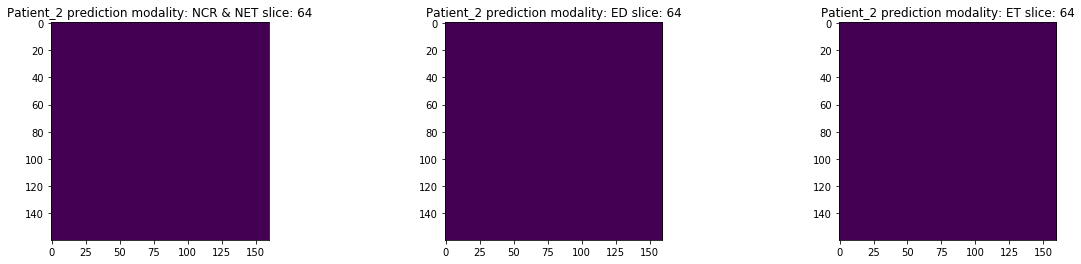

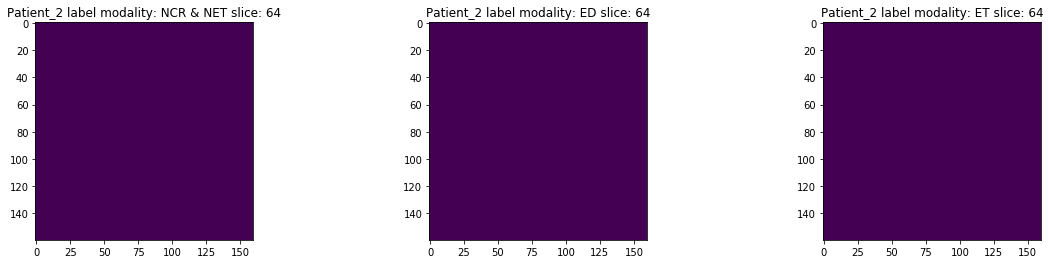

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


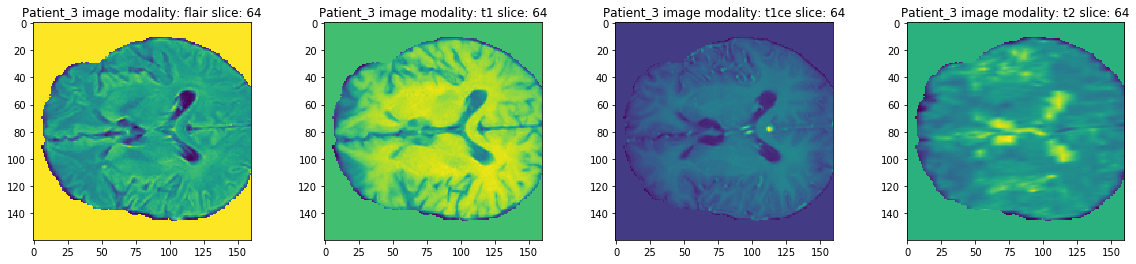

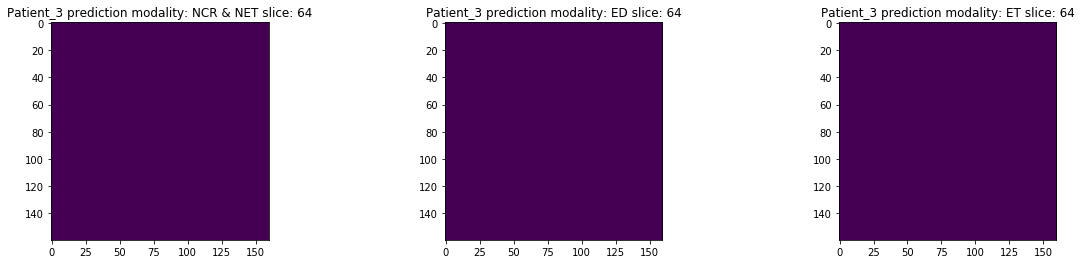

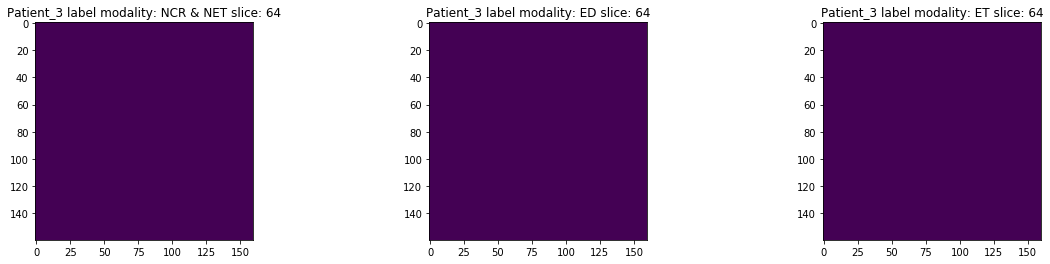

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


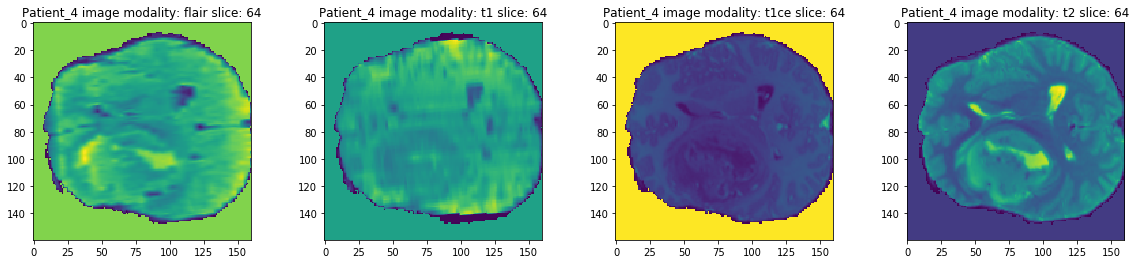

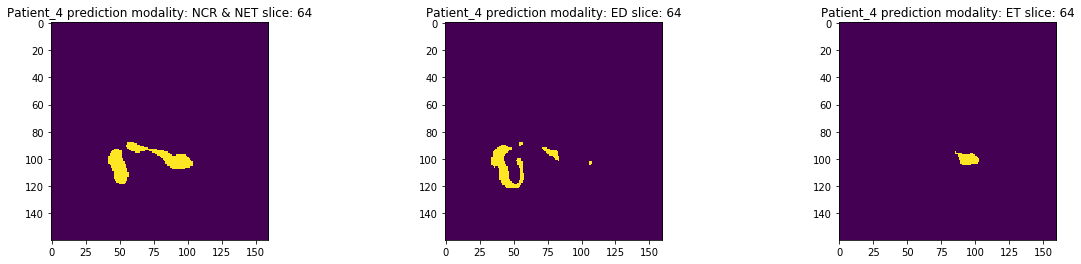

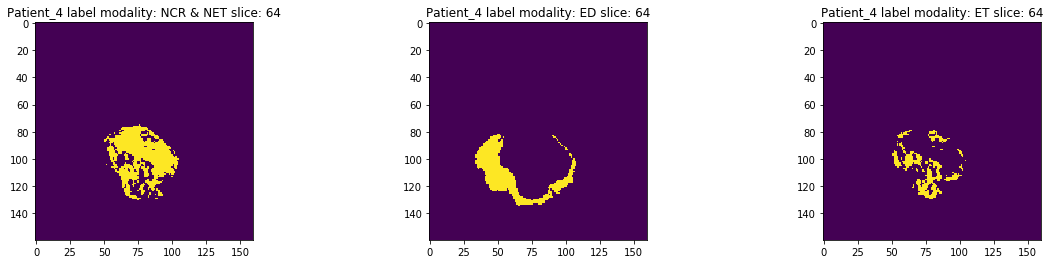

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


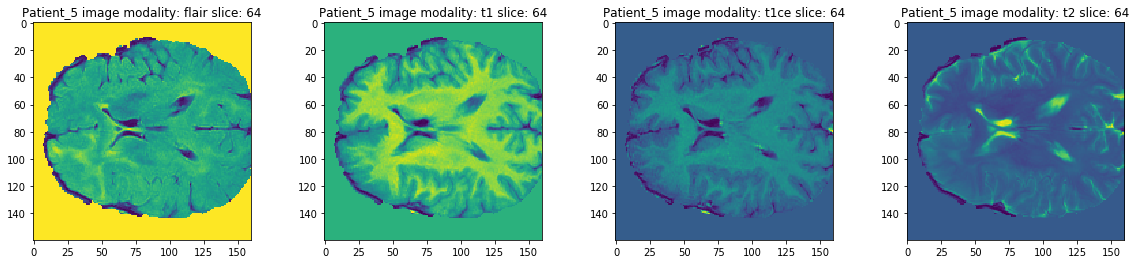

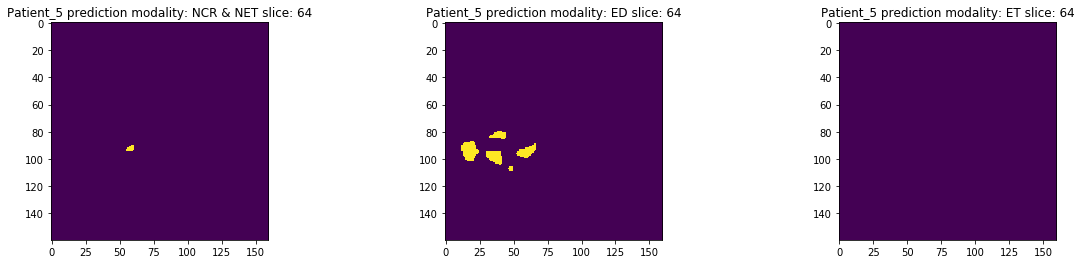

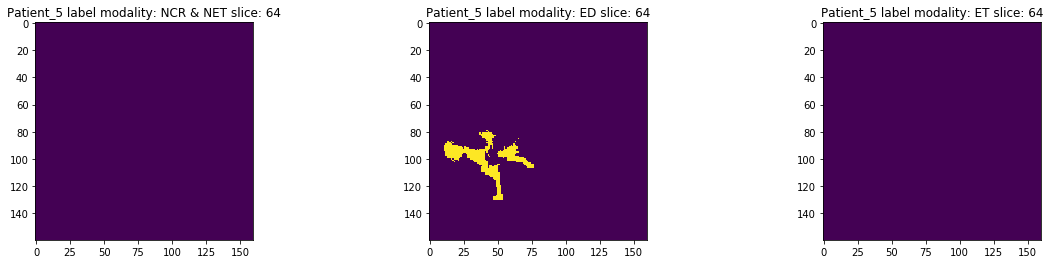

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


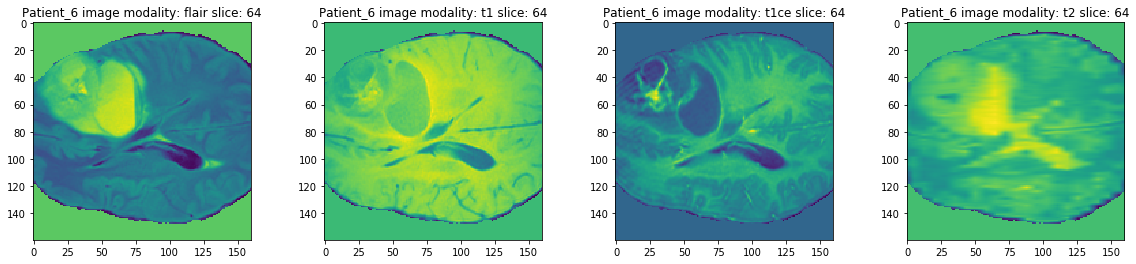

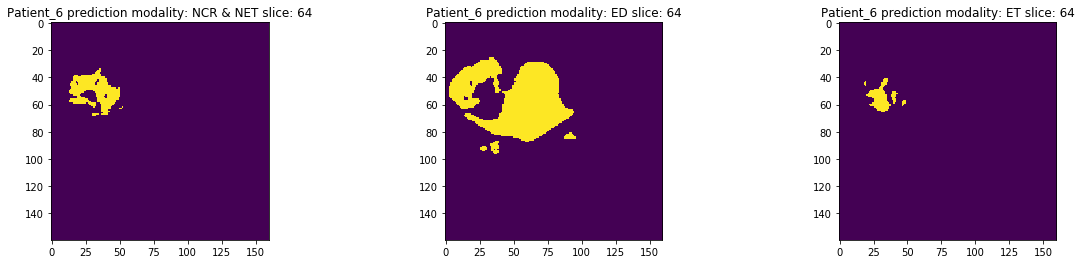

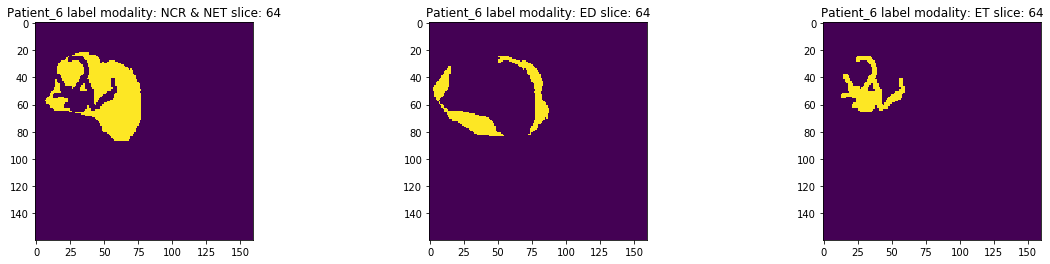

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


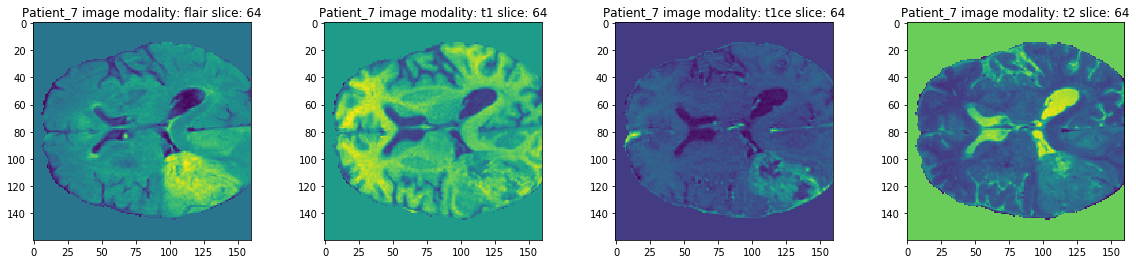

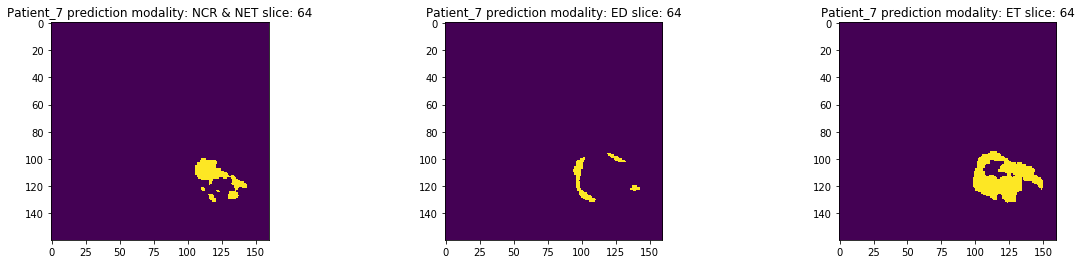

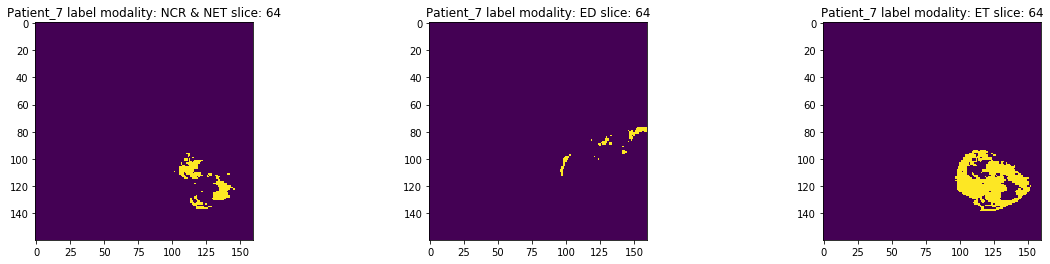

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


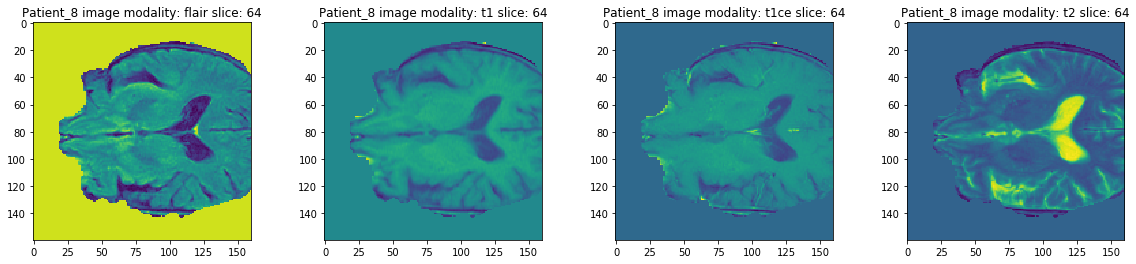

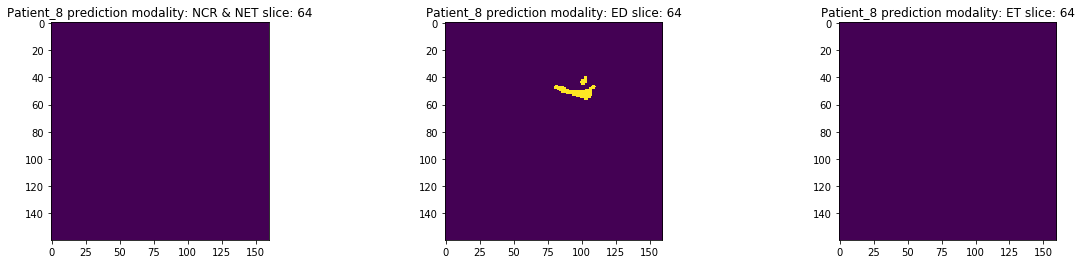

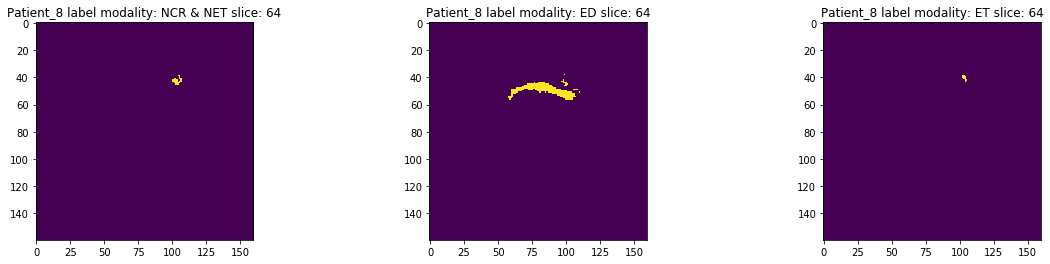

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


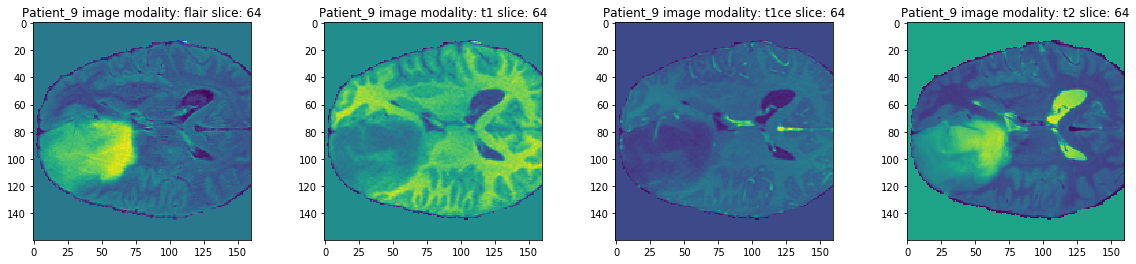

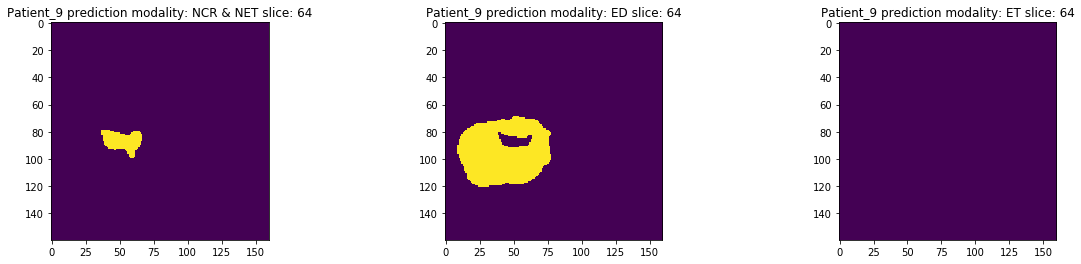

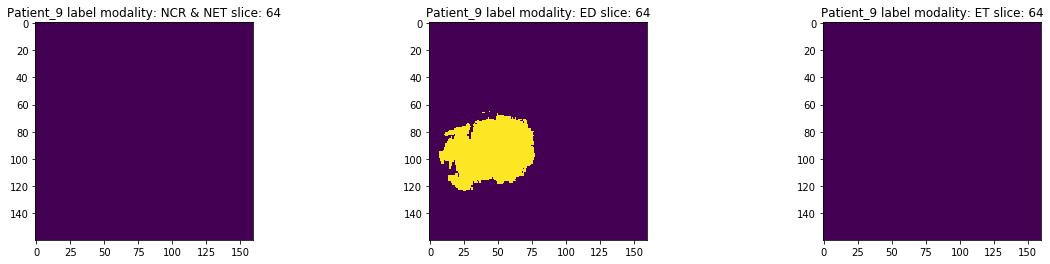

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


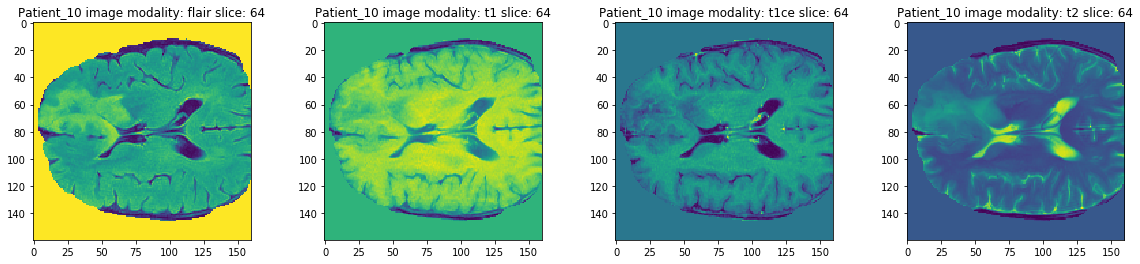

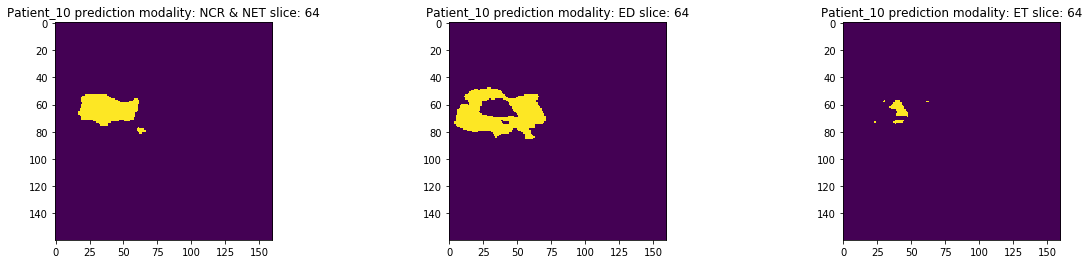

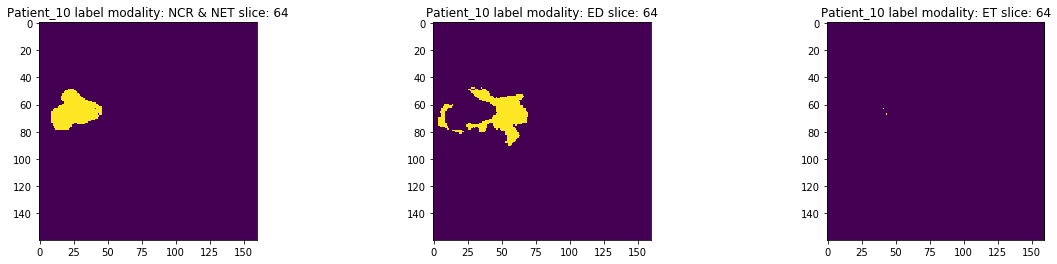

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


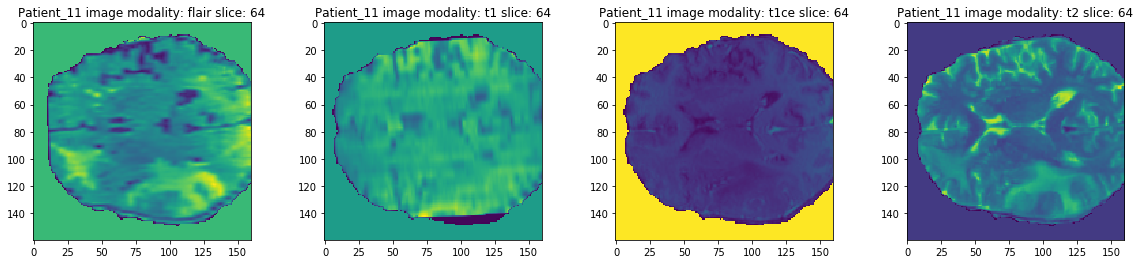

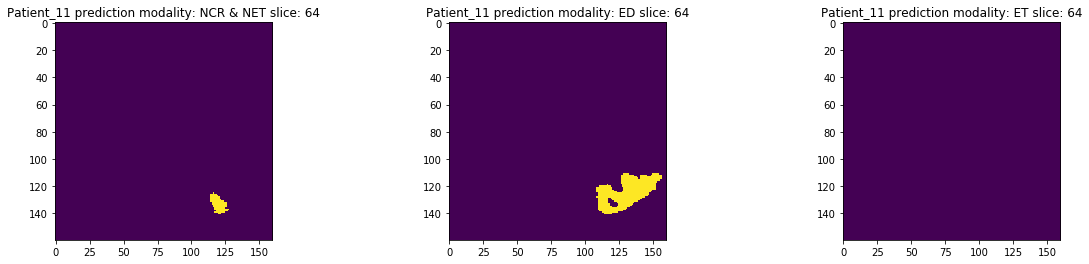

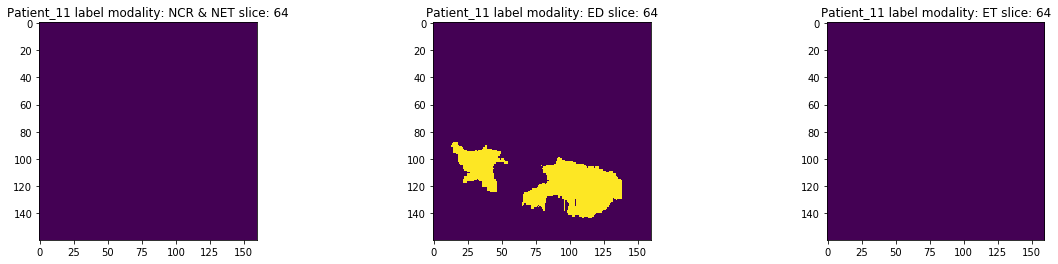

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


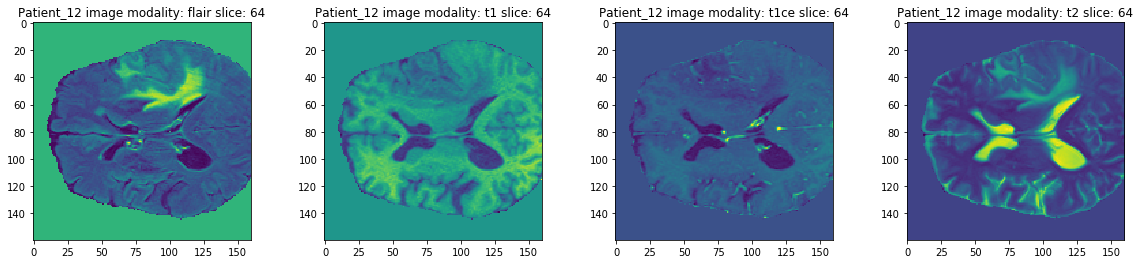

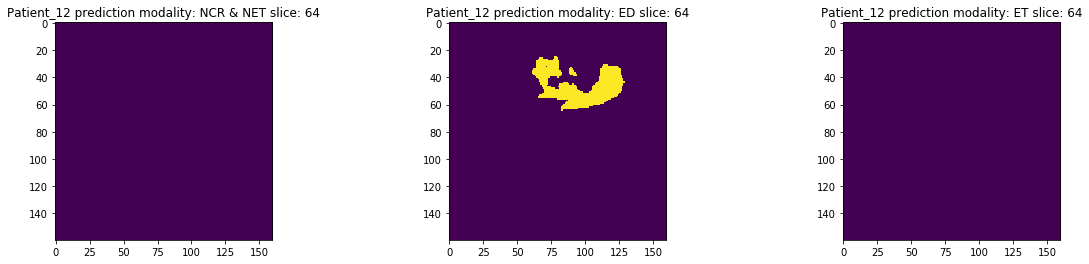

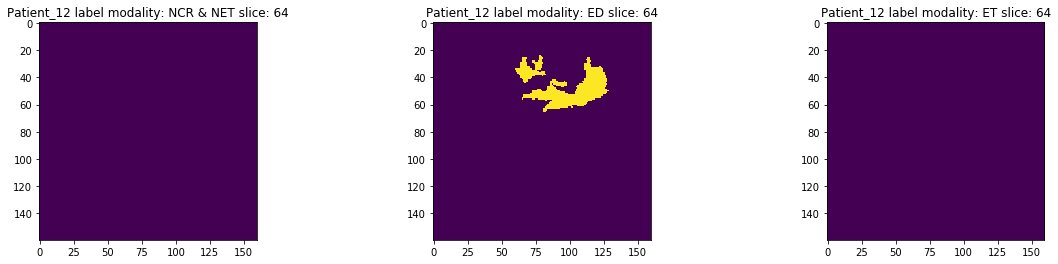

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


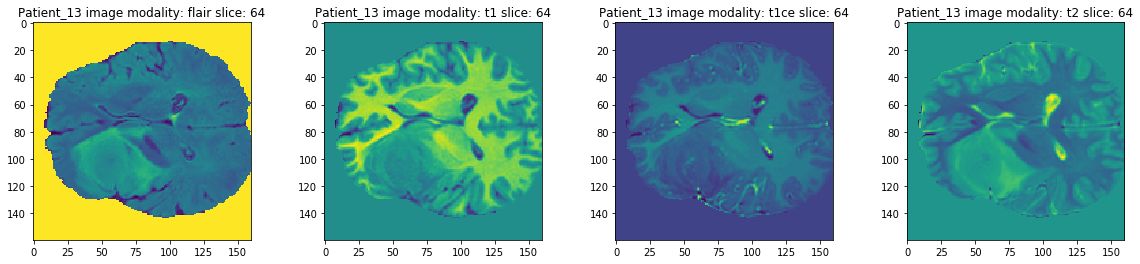

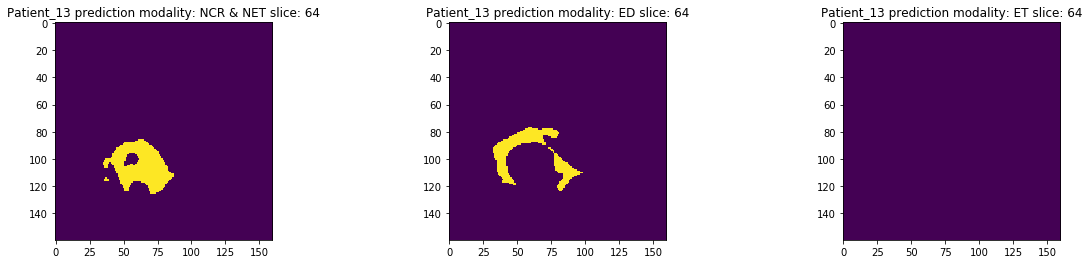

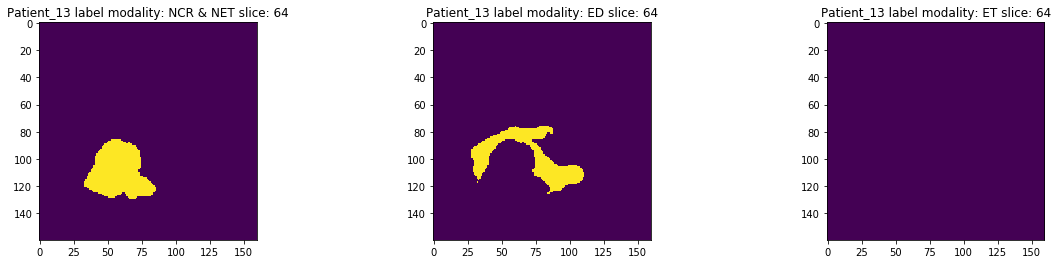

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


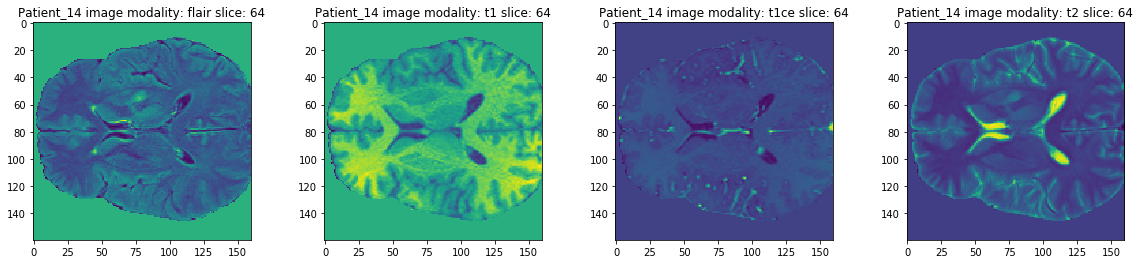

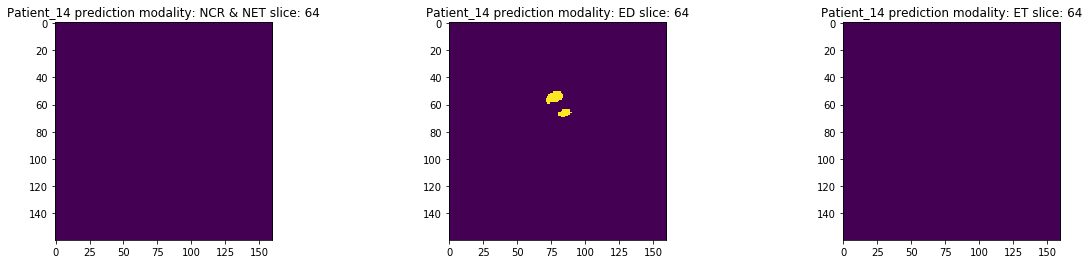

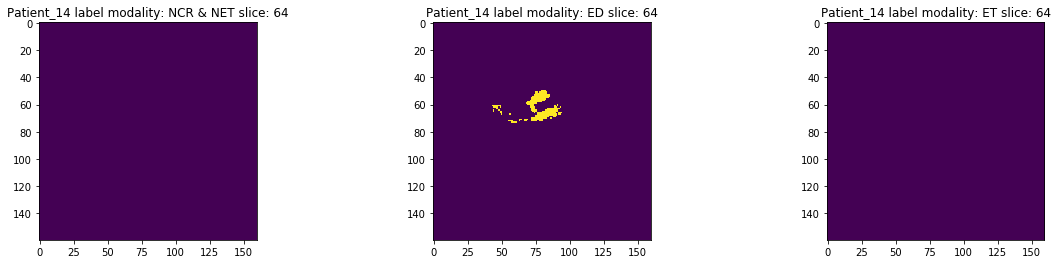

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


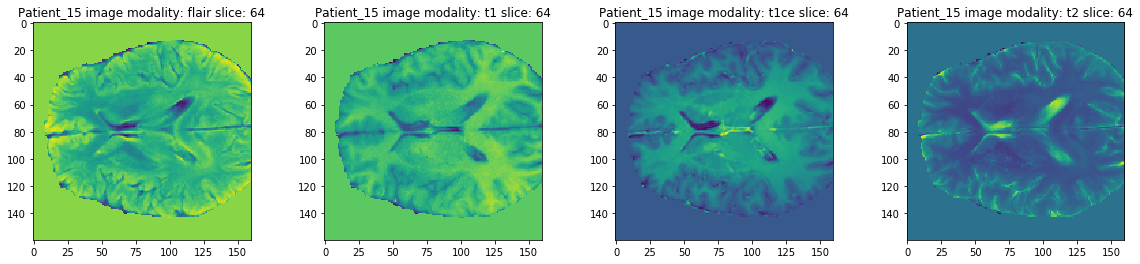

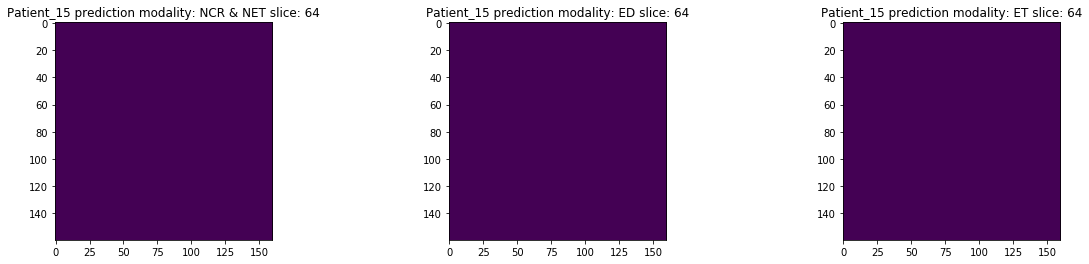

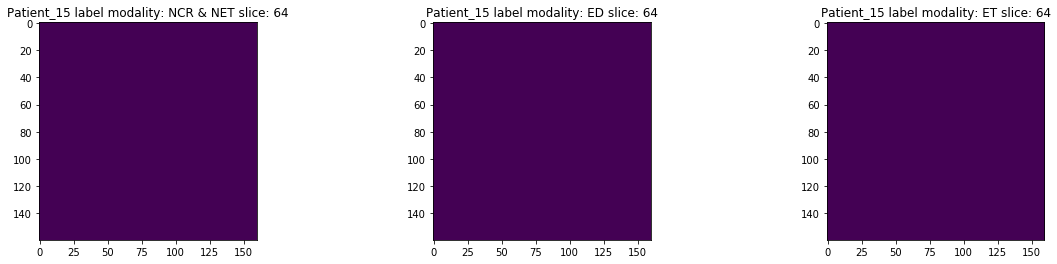

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


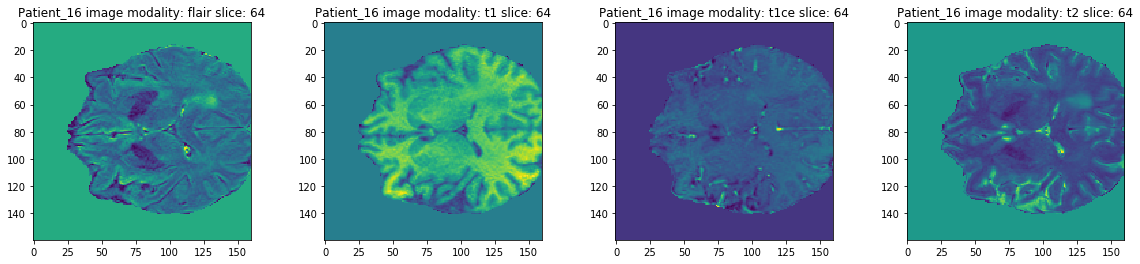

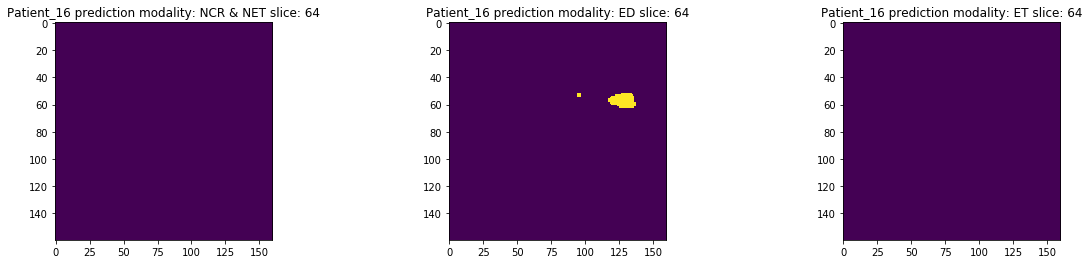

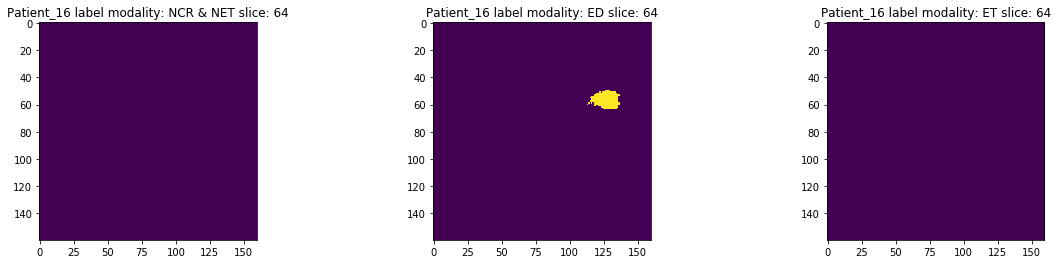

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


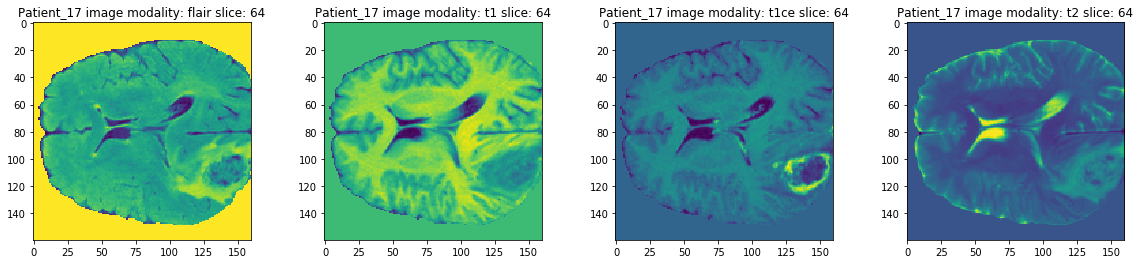

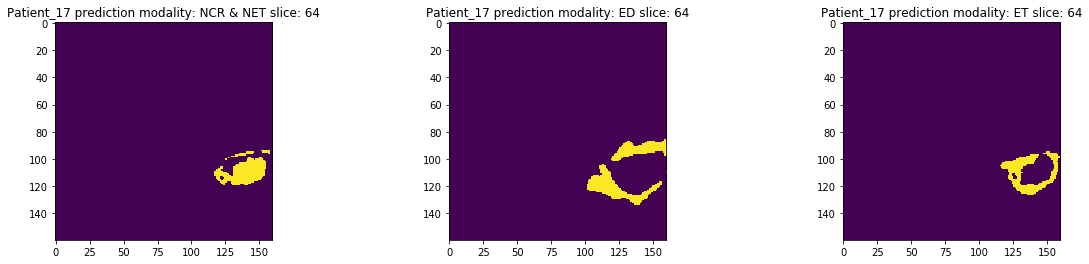

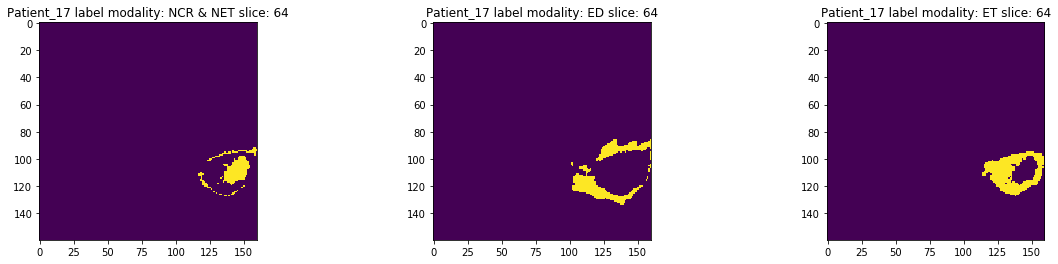

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


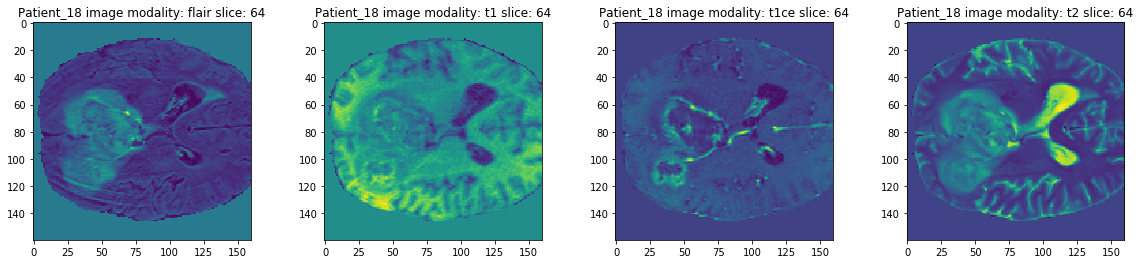

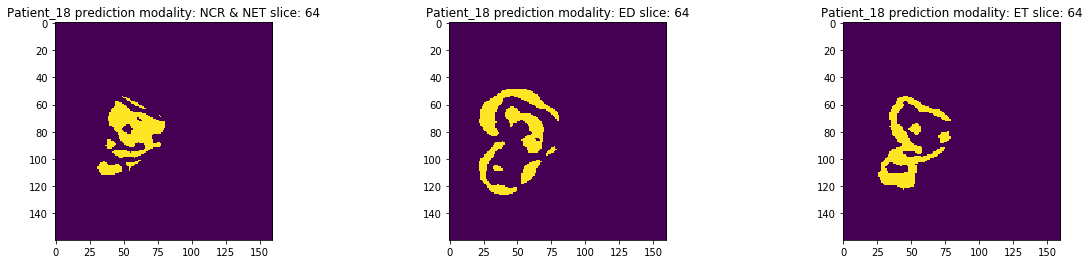

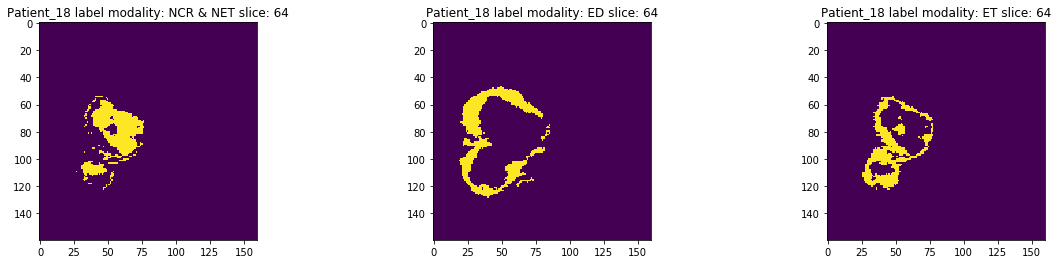

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


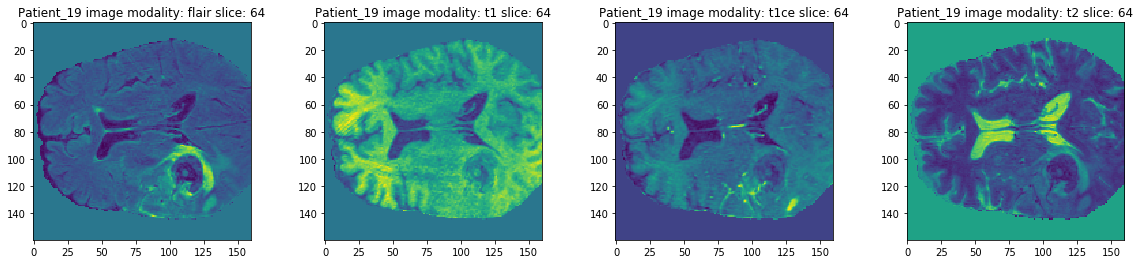

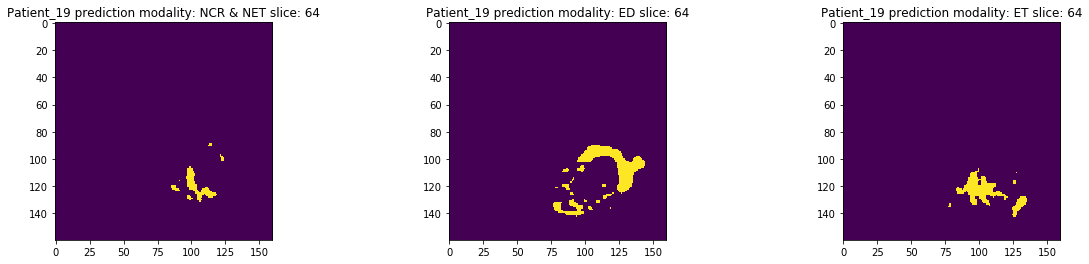

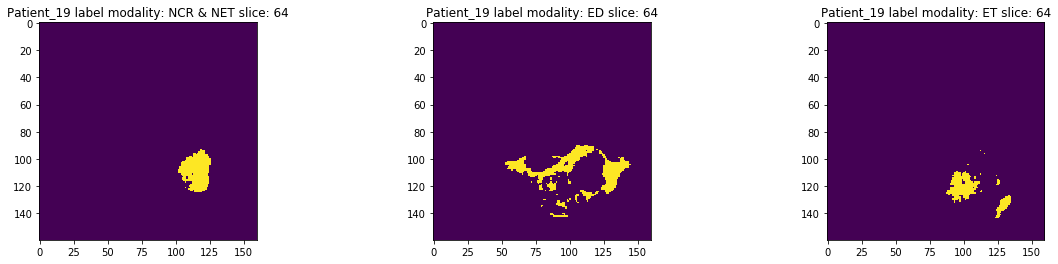

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


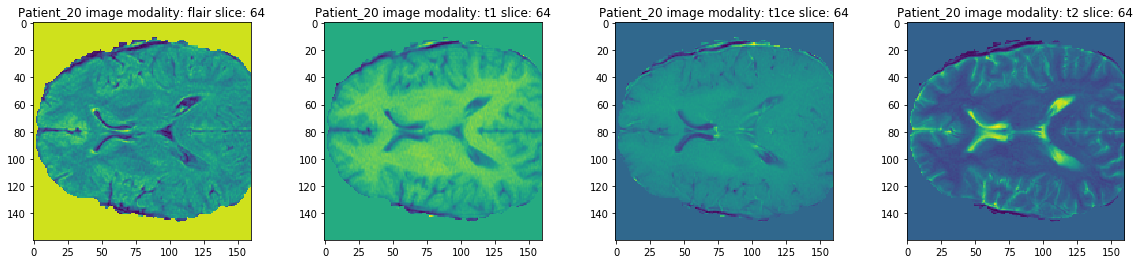

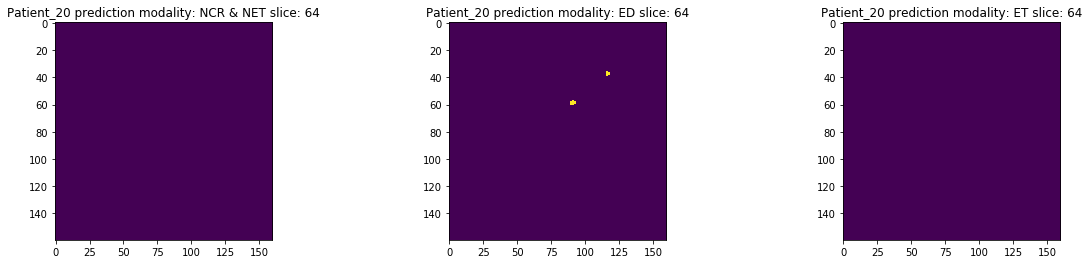

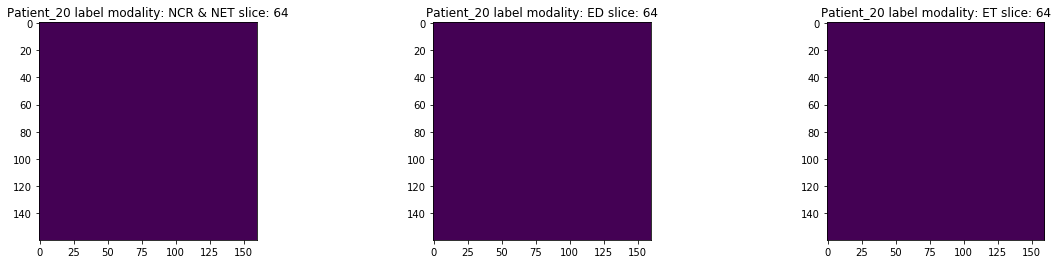

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


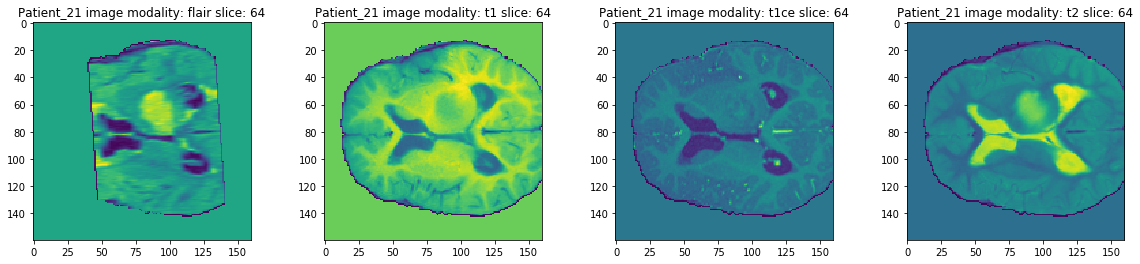

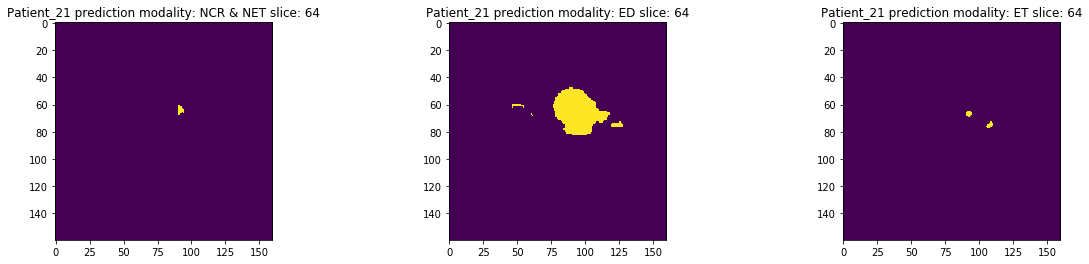

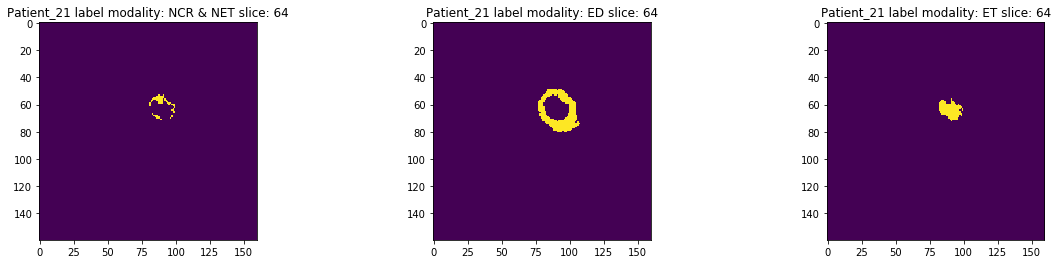

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


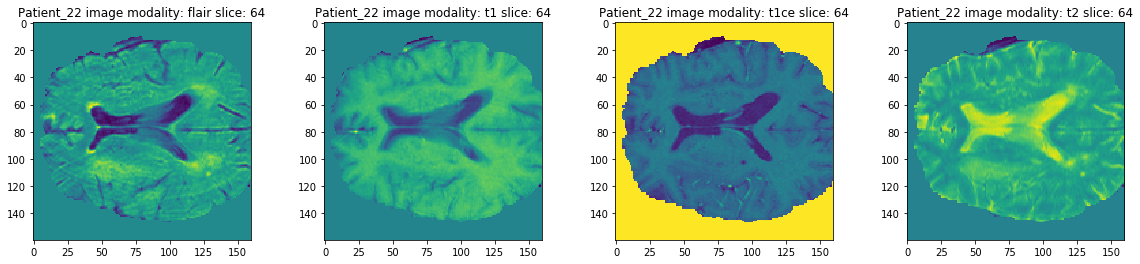

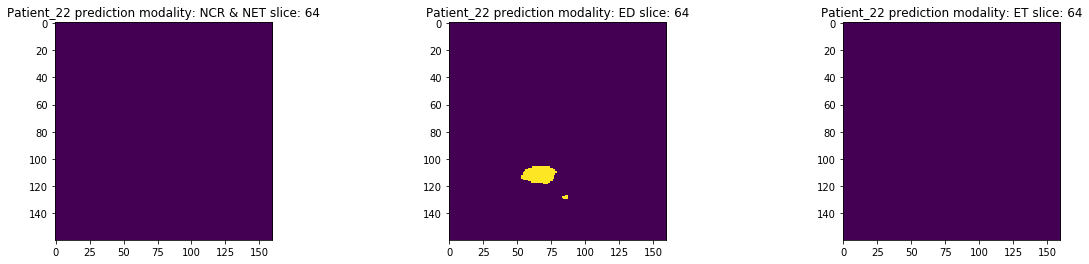

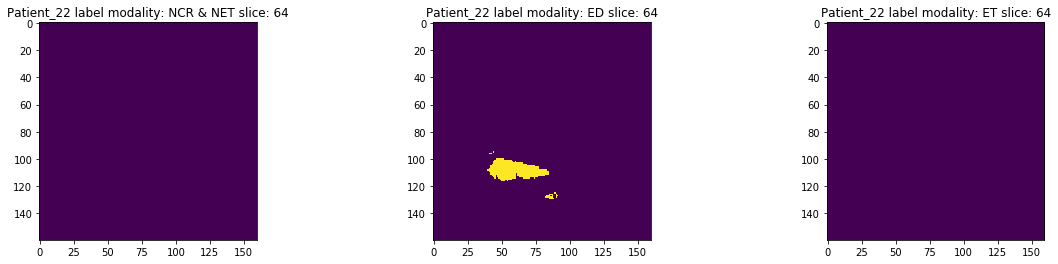

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


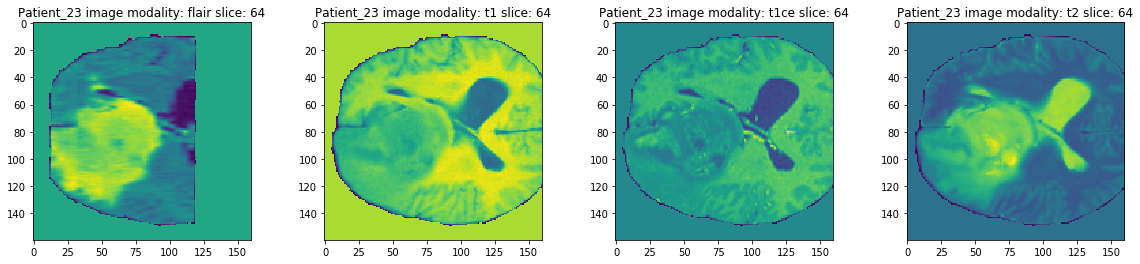

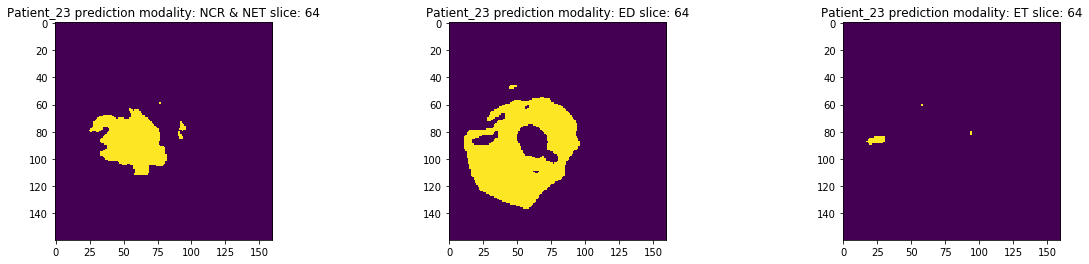

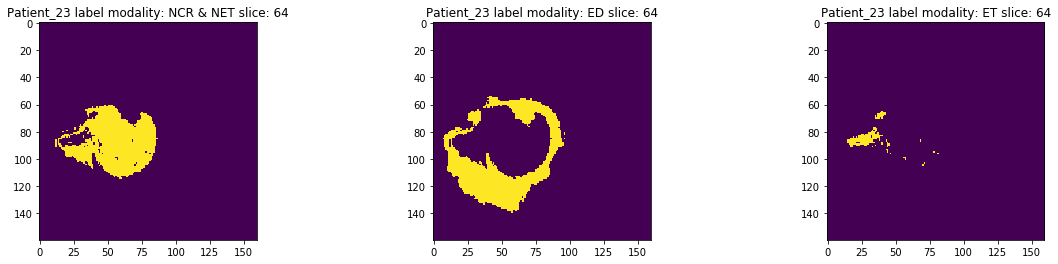

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


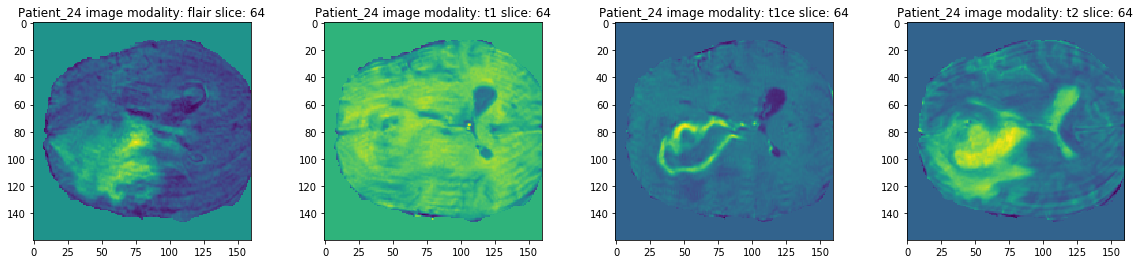

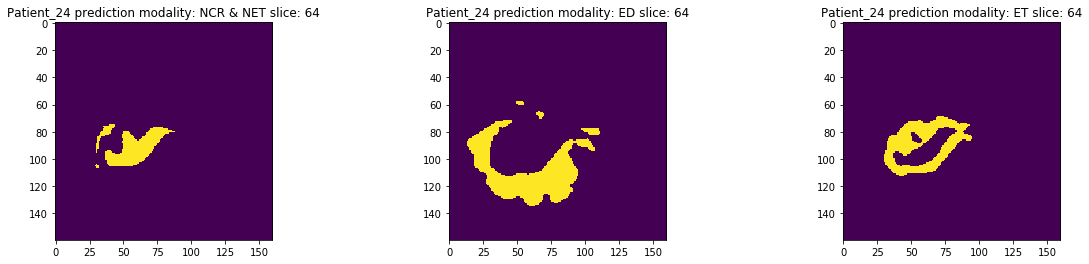

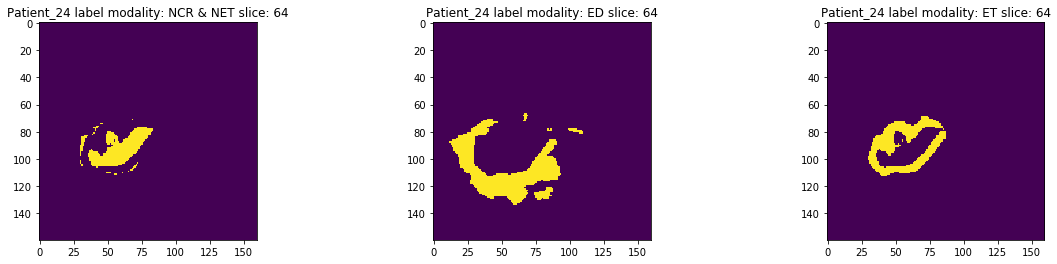

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


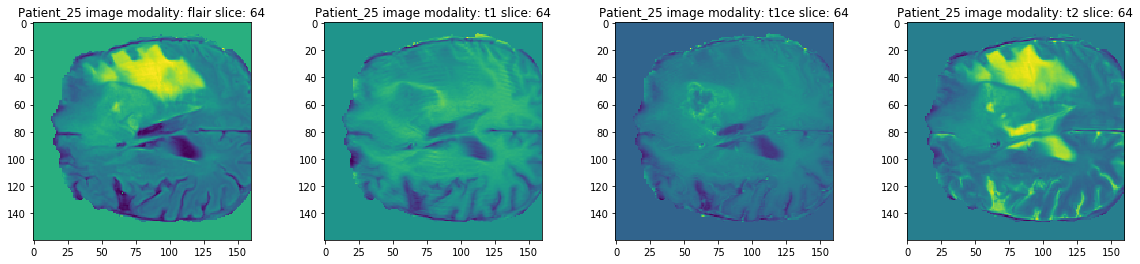

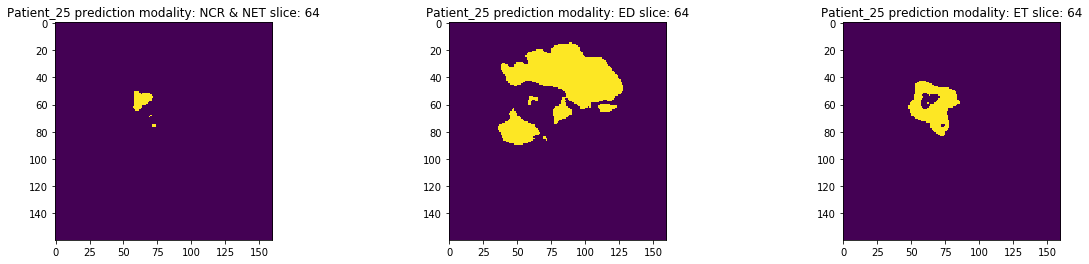

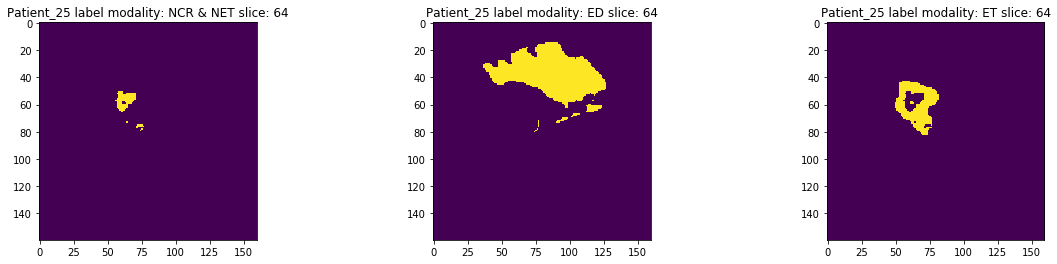

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


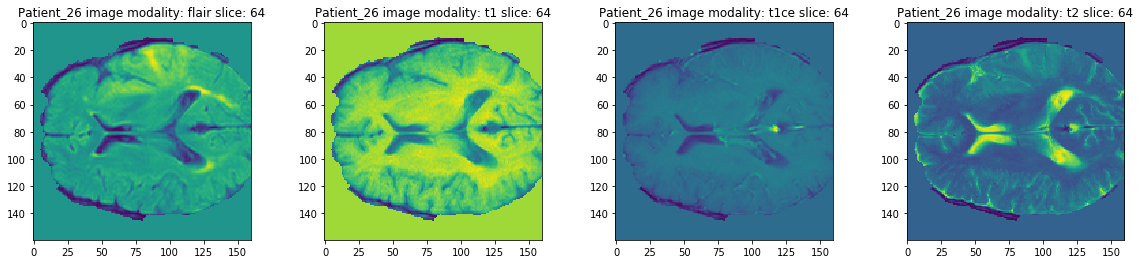

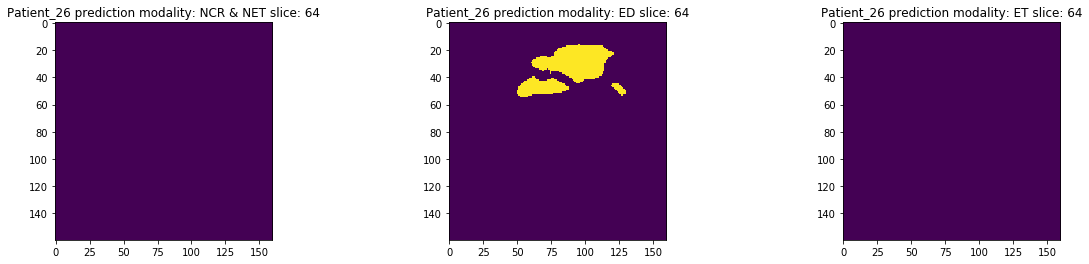

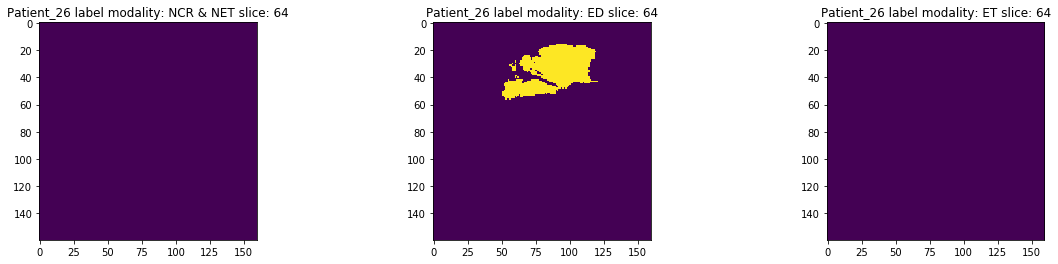

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


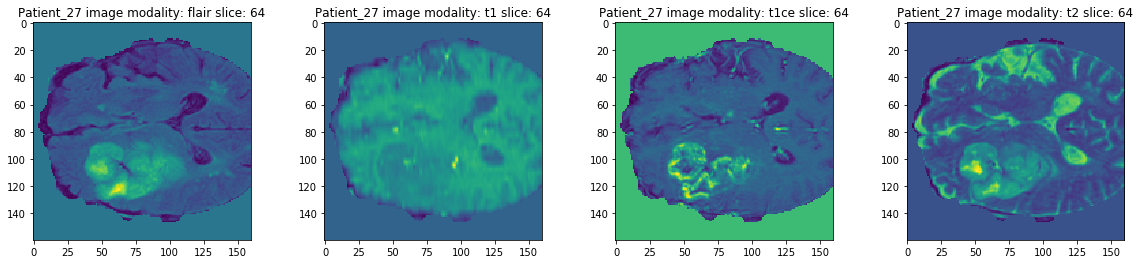

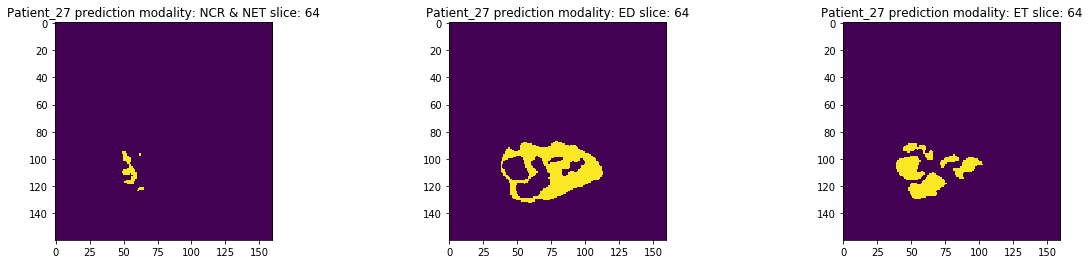

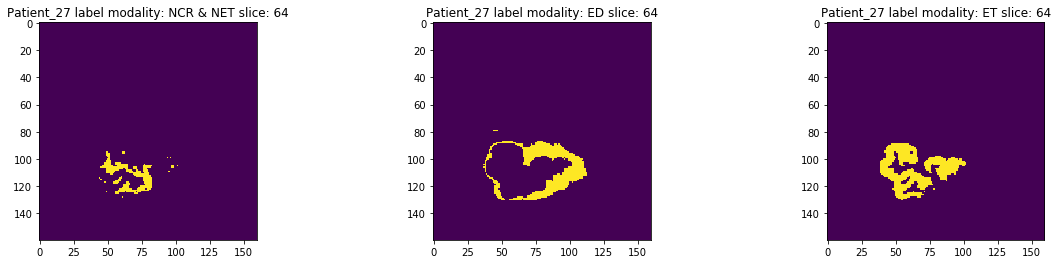

(4, 128, 160, 160) (3, 128, 160, 160) (3, 128, 160, 160)


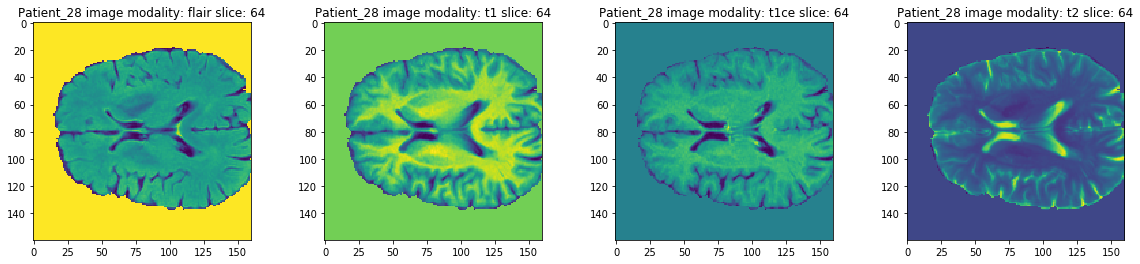

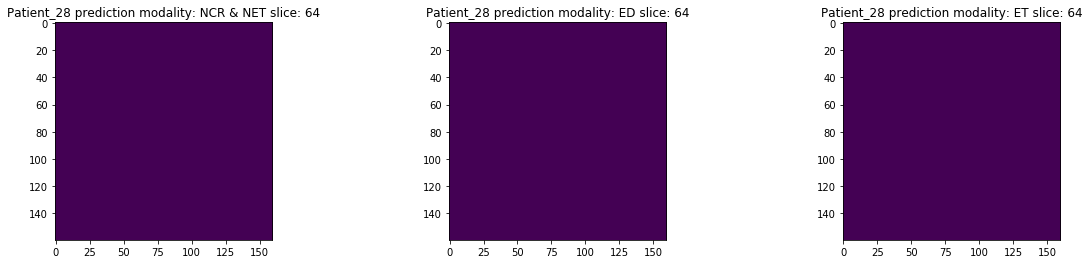

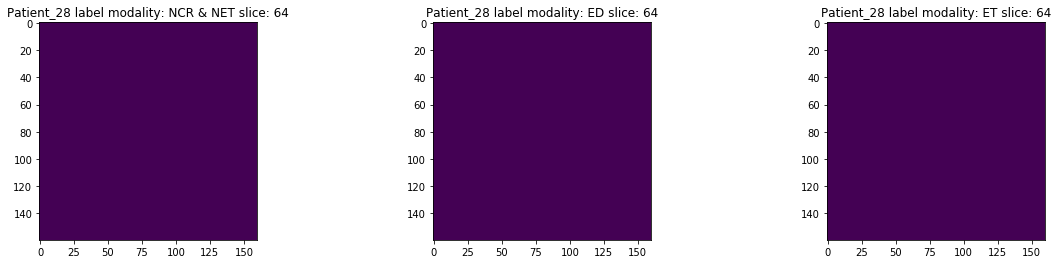

IndexError: list index out of range

In [13]:
for i in range(len(pred)):
    prediction = pred[i][0].cpu().numpy()
    prediction = (prediction >= 0.5).astype(int)
    label = tar[i][0].cpu().numpy()
    image = input_arr[i][0].cpu().numpy()
    print(image.shape, prediction.shape, label.shape)
    plot_original_img(image, 'image', 'Patient_' + str(i))
    plot_pred_img(prediction, 'prediction', 'Patient_' + str(i))
    plot_pred_img(label, 'label', 'Patient_' + str(i))

In [14]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [15]:
total = 0
for i in range(len(pred)):
    prediction = pred[i][0]
    prediction = (prediction >= 0.5)
    label = tar[i][0]
    total += dice_coeff(prediction, label)

print("Average DSC: ", total / len(pred))

Average DSC:  tensor(0.6621, device='cuda:0')


In [16]:
def DSC(dsc_type):
    total = 0
    for i in range(len(pred)):
        prediction = pred[i][0]
        prediction = (prediction >= 0.5).int()
        label = tar[i][0]
        if dsc_type == 'WT':
            prediction = ((prediction[0] + prediction[1] + prediction[2]) > 0.1).int()
            label = ((label[0] + label[1] + label[2]) > 0.1).int()
        elif dsc_type == 'TC':
            prediction = ((prediction[0] + prediction[2]) > 0.1).int()
            label = ((label[0] + label[2]) > 0.1).int()
        elif dsc_type == 'ET':
            prediction = prediction[2]
            label = label[2]
        total += dice_coeff(prediction, label)
    
    return total / len(pred)
        
WT_dsc = DSC('WT')
TC_dsc = DSC('TC')
ET_dsc = DSC('ET')

print('WT: ', WT_dsc, ' TC: ', TC_dsc, ' ET: ', ET_dsc)


WT:  tensor(0.8082, device='cuda:0')  TC:  tensor(0.6909, device='cuda:0')  ET:  tensor(0.5904, device='cuda:0')


In [17]:
pred_arr = []
label_arr = []
for i in range(len(pred)):
    pred_np = np.zeros((3, 155, 240, 240), dtype=np.float)
    tmp_pred = pred[i][0].cpu().numpy()
    pred_np[:, 13:141, 40:200, 40:200] = tmp_pred
    pred_arr.append(pred_np)
    
    label_np = np.zeros((3, 155, 240, 240), dtype=np.float)
    tmp_label = tar[i][0].cpu().numpy()
    label_np[:, 13:141, 40:200, 40:200] = tmp_label
    label_arr.append(label_np)
    
print(pred_arr[0].shape, label_arr[0].shape)

(3, 155, 240, 240) (3, 155, 240, 240)


In [18]:
def DSC_pad(pred_arr, label_arr, dsc_type):
    assert len(pred_arr) == len(label_arr), 'length of pred_arr must be the same as length of label_arr'
    total = 0
    for i in range(len(pred_arr)):
        prediction = torch.from_numpy(pred_arr[i])
        prediction = (prediction >= 0.5).int()
        label = torch.from_numpy(label_arr[i])
        if dsc_type == 'WT':
            prediction = ((prediction[0] + prediction[1] + prediction[2]) > 0.1).int()
            label = ((label[0] + label[1] + label[2]) > 0.1).int()
        elif dsc_type == 'TC':
            prediction = ((prediction[0] + prediction[2]) > 0.1).int()
            label = ((label[0] + label[2]) > 0.1).int()
        elif dsc_type == 'ET':
            prediction = prediction[2]
            label = label[2]
        
        d_c = dice_coeff(prediction, label)
        print(str(i) + ' ' + dsc_type + ': ', d_c)
        total += d_c
    
    return total / len(pred_arr)

WT_dsc = DSC_pad(pred_arr, label_arr, 'WT')
TC_dsc = DSC_pad(pred_arr, label_arr, 'TC')
ET_dsc = DSC_pad(pred_arr, label_arr, 'ET')

print('Padding to (3, 155, 240, 240)... ', 'WT: ', WT_dsc, ' TC: ', TC_dsc, ' ET: ', ET_dsc)

0 WT:  tensor(0.5712)
1 WT:  tensor(0.9458)
2 WT:  tensor(0.9448)
3 WT:  tensor(0.3763)
4 WT:  tensor(0.5757)
5 WT:  tensor(0.8714)
6 WT:  tensor(0.8758)
7 WT:  tensor(0.7478)
8 WT:  tensor(0.8540)
9 WT:  tensor(0.9026)
10 WT:  tensor(0.8756)
11 WT:  tensor(0.3984)
12 WT:  tensor(0.9231)
13 WT:  tensor(0.7403)
14 WT:  tensor(0.6825)
15 WT:  tensor(0.3630)
16 WT:  tensor(0.8827)
17 WT:  tensor(0.9258)
18 WT:  tensor(0.8772)
19 WT:  tensor(0.6914)
20 WT:  tensor(0.5460)
21 WT:  tensor(0.7487)
22 WT:  tensor(0.8483)
23 WT:  tensor(0.9456)
24 WT:  tensor(0.9222)
25 WT:  tensor(0.9219)
26 WT:  tensor(0.8948)
27 WT:  tensor(0.9235)
28 WT:  tensor(0.8483)
29 WT:  tensor(0.8299)
30 WT:  tensor(0.8369)
31 WT:  tensor(0.8343)
32 WT:  tensor(0.9221)
33 WT:  tensor(0.9115)
34 WT:  tensor(0.8294)
35 WT:  tensor(0.9341)
36 WT:  tensor(0.8892)
37 WT:  tensor(0.8089)
38 WT:  tensor(0.7624)
39 WT:  tensor(0.9222)
40 WT:  tensor(0.9570)
41 WT:  tensor(0.8803)
0 TC:  tensor(0.4546)
1 TC:  tensor(0.9059)


In [19]:
def sensitivity(seg, ground): 
    #computs false negative rate
    num=np.sum(np.multiply(ground, seg))
    denom=np.sum(ground)
    if denom==0:
        return 1
    else:
        return  num/denom

def specificity(seg, ground):
    #computes false positive rate
    num=np.sum(np.multiply(ground==0, seg==0))
    denom=np.sum(ground==0)
    if denom==0:
        return 1
    else:
        return  num/denom

In [20]:
tot_sen = 0
tot_spe = 0
for i in range(len(pred_arr)):
    prediction = pred_arr[i]
    prediction = (prediction >= 0.5).astype(int)
    label = label_arr[i].astype(int)
    
    sen = sensitivity(prediction, label)
    spe = specificity(prediction, label)
    print(str(i), ' ', 'Sens: ', sen, ' Spec: ', spe)
    
    tot_sen += sen
    tot_spe += spe

print('Sensitivity: ', tot_sen / len(pred_arr), ' Specificity: ', tot_spe / len(pred_arr))

0   Sens:  0.31771840161004156  Spec:  0.9990439324995872
1   Sens:  0.9127169308725303  Spec:  0.9994046651155081
2   Sens:  0.8607916816801359  Spec:  0.999487313328111
3   Sens:  0.6917808219178082  Spec:  0.9976997351730968
4   Sens:  0.3452896443266766  Spec:  0.9986860447481141
5   Sens:  0.5159299730746263  Spec:  0.9982498862527232
6   Sens:  0.4603593361582689  Spec:  0.9956754021150473
7   Sens:  0.651608471923523  Spec:  0.9990750393263745
8   Sens:  0.6711549480232463  Spec:  0.9995126976274578
9   Sens:  0.8295361001821375  Spec:  0.9986088100585057
10   Sens:  0.754716568176844  Spec:  0.9989556557613402
11   Sens:  0.17088305168016044  Spec:  0.9989302962938852
12   Sens:  0.9051904252693921  Spec:  0.9992532563611044
13   Sens:  0.49937653116610675  Spec:  0.9992250353182902
14   Sens:  0.7144125326370757  Spec:  0.9994647457392812
15   Sens:  0.3978674351585014  Spec:  0.9953236907134019
16   Sens:  0.7818216282816794  Spec:  0.9995463281523799
17   Sens:  0.8368124479

In [21]:
def sens_spec(pred_arr, label_arr, dsc_type):
    assert len(pred_arr) == len(label_arr), 'length of pred_arr must be the same as length of label_arr'
    tot_sens = 0
    tot_spec = 0
    for i in range(len(pred_arr)):
        prediction = pred_arr[i]
        prediction = (prediction >= 0.5).astype(int)
        label = label_arr[i].astype(int)
        if dsc_type == 'WT':
            prediction = ((prediction[0] + prediction[1] + prediction[2]) > 0).astype(int)
            label = ((label[0] + label[1] + label[2]) > 0).astype(int)
        elif dsc_type == 'TC':
            prediction = ((prediction[0] + prediction[2]) > 0).astype(int)
            label = ((label[0] + label[2]) > 0).astype(int)
        elif dsc_type == 'ET':
            prediction = prediction[2]
            label = label[2]
        
        sens = sensitivity(prediction, label)
        spec = specificity(prediction, label)
        print(str(i), ' ', dsc_type, ' Sens: ', sens, ' Spec: ', spec)
        
        tot_sens += sens
        tot_spec += spec
    
    return tot_sens / len(pred_arr), tot_spec / len(pred_arr)

WT_sens, WT_spec = sens_spec(pred_arr, label_arr, 'WT')
TC_sens, TC_spec = sens_spec(pred_arr, label_arr, 'TC')
ET_sens, ET_spec = sens_spec(pred_arr, label_arr, 'ET')

print('WT_sens: ', WT_sens, 'WT_spec: ', WT_spec)
print('TC_sens: ', TC_sens, 'TC_spec: ', TC_spec)
print('ET_sens: ', ET_sens, 'ET_spec: ', ET_spec)

0   WT  Sens:  0.415450749852148  Spec:  0.9994973176091649
1   WT  Sens:  0.9491883555813697  Spec:  0.999344142781589
2   WT  Sens:  0.9255572141864415  Spec:  0.9996282357390811
3   WT  Sens:  0.8987823439878234  Spec:  0.9944831722163755
4   WT  Sens:  0.4275332658322382  Spec:  0.9990861036669294
5   WT  Sens:  0.7998721830506343  Spec:  0.9996116637198019
6   WT  Sens:  0.8699840621413302  Spec:  0.9975449903083898
7   WT  Sens:  0.7004087331524248  Spec:  0.998264433535701
8   WT  Sens:  0.7949987722026685  Spec:  0.999816814970541
9   WT  Sens:  0.900193804730391  Spec:  0.9983385612558229
10   WT  Sens:  0.9177500547165682  Spec:  0.9990821081452911
11   WT  Sens:  0.2613485701979312  Spec:  0.9991444758322681
12   WT  Sens:  0.9423130706588797  Spec:  0.9986278208082049
13   WT  Sens:  0.5910631243856999  Spec:  0.9999100284291965
14   WT  Sens:  0.7627154046997389  Spec:  0.9989849419397565
15   WT  Sens:  0.7552161383285303  Spec:  0.9906109093362419
16   WT  Sens:  0.86257